In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
# 加载数据集

dataset = pd.read_csv("BikeShares.csv", parse_dates=['timestamp'], index_col=['timestamp'])

In [4]:
dataset.shape

(17414, 9)

In [4]:
# 分别对字段t1, t2, hum, wind_speed进行归一化

columns = ['cnt', 't1', 't2', 'hum', 'wind_speed']

for col in columns:
    scaler = MinMaxScaler()
    dataset[col] = scaler.fit_transform(dataset[col].values.reshape(-1,1))

In [5]:
# 特征数据集

X = dataset.drop(columns=['cnt'], axis=1) 

# 标签数据集

y = dataset['cnt']

In [7]:
# 1 数据集分离： X_train, X_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=False, # 时间序列的数据要关闭shuffle
                                                    random_state=666)

In [12]:
# 2 构造特征数据集

def create_dataset(X, y, seq_len=10):
    features = []
    targets = []
    
    for i in range(0, len(X) - seq_len, 1):
        data = X.iloc[i:i+seq_len] # 序列数据
        label = y.iloc[i+seq_len] # 标签数据
        # 保存到features和labels
        features.append(data)
        targets.append(label)
    return np.array(features), np.array(targets)

seq_len = 10
# ① 构造训练特征数据集
train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=seq_len)
# ② 构造测试特征数据集
test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=seq_len)

In [23]:
seq_len = 10

In [15]:
# 3 构造批数据

def create_batch_dataset(X, y, train=True, buffer_size=1000, batch_size=128):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # 数据封装，tensor类型
    if train: # 训练集
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else: # 测试集
        return batch_data.batch(batch_size)

# 训练批数据

train_batch_dataset = create_batch_dataset(train_dataset, train_labels)

# 测试批数据

test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

In [20]:
# 从测试批数据中，获取一个batch_size的样本数据

list(test_batch_dataset.as_numpy_iterator())[0][0].shape

(128, 10, 8)

In [38]:
embedding_dimention = X_train.shape[1]

In [98]:
def convolution():
    filter_size = [3,4,5]
    embedding_dimention = 64
    inn = layers.Input(shape=(seq_len,embedding_dimention,1)) # 3维
    cnns = []
    for filter in filter_size:
        conv = layers.Conv2D(filters=64,kernel_size=(filter,embedding_dimention), # 卷积大小是filter × embedding_dimention
                            strides=1,activation='relu')(inn)
                            
        # conv生成64个((seq_len-filter+2*0)/1+1,1)特征图，将每个特征图pooling成一个特征，得到64个特征
        pool = layers.MaxPool2D(pool_size=((seq_len-filter+2*0)/1+1,1))(conv)
        cnns.append(pool)
    # 将不同卷积大小下的结果拼接在一起
    outt = layers.concatenate(cnns)
    model = Model(inputs = inn, outputs = outt)
    return model

def cnn_mulfilter():
    model = Sequential([
        layers.LSTM(64, input_shape=train_dataset.shape[-2:],return_sequences=True),
        layers.Dropout(0.2),
        layers.Bidirectional(layers.LSTM(32,return_sequences=True)),
        layers.Dropout(0.2),
        convolution(),
        layers.Flatten(),
        layers.Dense(10,activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])

    model.compile(optimizer='adam',loss='mse')
    return model
model = cnn_mulfilter()
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 10, 64)            18688     
_________________________________________________________________
dropout_37 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 10, 64)            24832     
_________________________________________________________________
dropout_38 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
functional_35 (Functional)   (None, 1, 1, 192)         49344     
_________________________________________________________________
flatten_22 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 10)              

In [99]:
# 存模型

checkpoint_file = "best_model.hdf5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file, 
                                      monitor='loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)  # 将loss最小的那个模型保存下来
# 模型训练

history = model.fit(train_batch_dataset,
                    epochs=50,
                    validation_data=test_batch_dataset,
                    # callbacks=[stop_callback, checkpoint_callback]
                    callbacks=checkpoint_callback
                   )

Epoch 1/50
109/109 [==============================] - 2s 22ms/step - loss: 0.0193 - val_loss: 0.0188
Epoch 2/50
109/109 [==============================] - 1s 12ms/step - loss: 0.0156 - val_loss: 0.0151
Epoch 3/50
109/109 [==============================] - 1s 12ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 4/50
109/109 [==============================] - 1s 13ms/step - loss: 0.0127 - val_loss: 0.0139
Epoch 5/50
109/109 [==============================] - 1s 13ms/step - loss: 0.0123 - val_loss: 0.0130
Epoch 6/50
109/109 [==============================] - 1s 12ms/step - loss: 0.0122 - val_loss: 0.0131
Epoch 7/50
109/109 [==============================] - 1s 13ms/step - loss: 0.0119 - val_loss: 0.0126
Epoch 8/50
109/109 [==============================] - 1s 13ms/step - loss: 0.0117 - val_loss: 0.0134
Epoch 9/50
109/109 [==============================] - 1s 13ms/step - loss: 0.0114 - val_loss: 0.0120
Epoch 10/50
109/109 [==============================] - 1s 12ms/step - loss: 0.0111 - val_lo

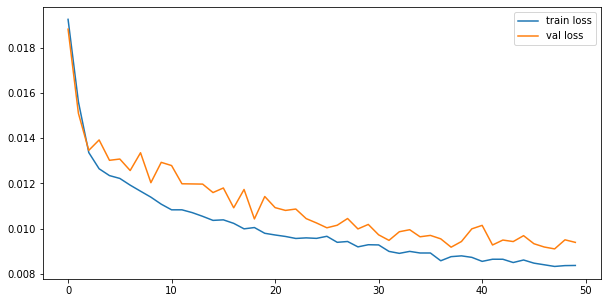

In [100]:
# 显示训练结果

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

In [101]:
train_preds = model.predict(train_dataset, verbose=1)
test_preds = model.predict(test_dataset, verbose=1)

score_train = r2_score(train_labels, train_preds)
score_test = r2_score(test_labels, test_preds)

print(f"r^2 值为：{score_train,score_test}")

109/109 [==============================] - 1s 6ms/step
r^2 值为：(0.6425637844994125, 0.5436876541606682)
